In [1]:
%matplotlib inline

In [2]:
from __future__ import division, unicode_literals, print_function
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

なお，PythonからRを使いたい人は以下のいずれかを実行します．

* pip install pyper
* conda install -c chieima pyper <sub>(linuxの場合はpyperではなくauto)</sub>

そして，以下を実行してrを使う準備をしておきます．

In [3]:
import pyper
r = pyper.R(use_pandas=True)

この分析ノートブックでは

```
# with R
```

で始まるブロックにRを使います．
pyperを使わないなら無視して構いません．

pyperを使わなくても，Jupyter NotebookはRのノートブックを作成できるので問題ありません．
とはいえpyperは，わざわざノートブックを作るまでもない，ちょこっとRを呼び出したい場合に便利です．

## 1. 前処理 (続き)

In [4]:
df = pd.read_csv('result_congruency.csv', encoding='utf-8')
df.head()

,subj,congruency,RT
0,1,congruent,375.800000
1,1,incongruent,479.125000
2,2,congruent,380.000000
3,2,incongruent,492.852941
4,3,congruent,387.875000


In [5]:
# 被験者条件を潰して，もう一度集計
df_groupby = df.groupby(by=['congruency'])
df_mean = df_groupby['RT'].mean()
df_sem = df_groupby['RT'].sem()

In [6]:
# 独自の関数を適用 (apply) することもできる
def cilen(arr, alpha=0.95):  # 両側95%信頼区間
    m, e, df = np.mean(arr), stats.sem(arr), len(arr) - 1
    interval = stats.t.interval(alpha, df, loc=m, scale=e)
    cilen = np.max(interval) - np.mean(interval)
    return cilen

df_ci = df_groupby['RT'].apply(cilen)

## 2. 可視化
作図方法については[公式のギャラリー](http://matplotlib.org/gallery.html)を参照すると良い．

### 2.1. ざっくりプロット

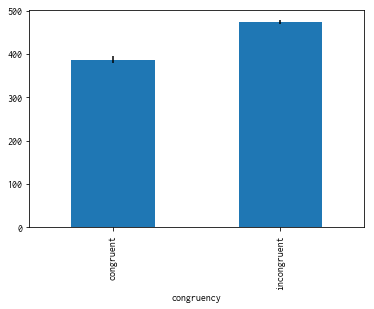

In [7]:
df_mean.plot(kind='bar', yerr=df_sem)

### 2.2. しっかりプロット

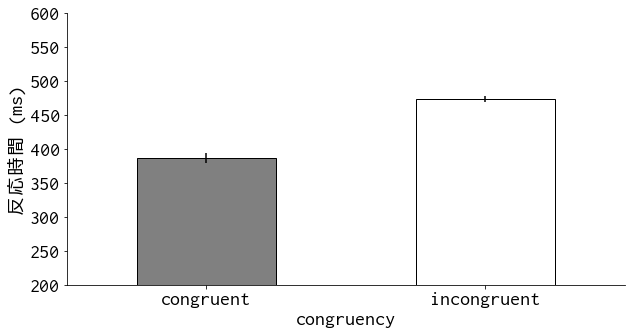

In [8]:
fig, ax = plt.subplots(figsize=(10, 5))
df_mean.plot(
    kind='bar',
    rot=0,  # ラベルの回転を0度に設定
    yerr=df_sem,
    color=('gray', 'white'),
    edgecolor='black',
    fontsize=20,
    ax=ax
)

ax.set_xlabel('congruency', fontsize=20)
ax.set_ylabel('反応時間 (ms)', fontsize=20)
ax.set_ylim(200, 600)
ax.spines['right'].set_visible(False)  # 右側の枠を消す
ax.spines['top'].set_visible(False)  # 上側の枠を消す

## 3. 分析
### 3.1. t検定

In [9]:
table = df.set_index(['subj', 'congruency'])['RT'].unstack()
table.head()

congruency,congruent,incongruent
subj,,
1,375.800000,479.125000
2,380.000000,492.852941
3,387.875000,471.363636
4,353.647059,471.583333
5,383.333333,494.500000


#### 対応あり

In [10]:
t, p = stats.ttest_rel(table['congruent'], table['incongruent'])
print(t, p)

-9.41180511457 1.3846504615e-08


In [11]:
# with R

# pythonで作ったdfをrのdatという変数に割り当てる．
r.assign('dat', df)

# Rコードを実行する
r("""
dat.c <- dat[dat$congruency == 'congruent', 'RT']
dat.i <- dat[dat$congruency == 'incongruent', 'RT']
""")

# t.testの結果はPythonと一致している
print(r("t.test(dat.c, dat.i, paired = T)"))

try({t.test(dat.c, dat.i, paired = T)})

	Paired t-test

data:  dat.c and dat.i
t = -9.4118, df = 19, p-value = 1.385e-08
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -105.58562  -67.16815
sample estimates:
mean of the differences 
              -86.37689 




#### 対応なし

In [12]:
t, p = stats.ttest_ind(table['congruent'], table['incongruent'])
print(t, p)

-9.91026349599 4.38352228724e-12


In [13]:
# with R
print(r("t.test(dat.c, dat.i, paired = F)"))

try({t.test(dat.c, dat.i, paired = F)})

	Welch Two Sample t-test

data:  dat.c and dat.i
t = -9.9103, df = 31.938, p-value = 2.885e-11
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -104.13195  -68.62182
sample estimates:
mean of x mean of y 
 386.9838  473.3607 




### 3.2. 分散分析
Pythonのstatsmodelsでは反復測定ANOVAの分析ができません．分散分析だけはRを呼んだほうが楽です．

Rで分散分析するならaov…に見せかけて，楽したいという人はanova君を使うのが最も良いです (なお，標準aovは非釣り合いデータの補正に問題が有るそうです)．

Excel分析派の人も，分散分析だけはanova君を使えば良いのではないかと思います．

In [14]:
# with R
print(r("""
source('anovakun_462.txt')
anovakun(dat, 'sA', long=T, peta=T, holm=T)
""")) #  anova君にお任せしましょう．

try({
+ source('anovakun_462.txt')
+ anovakun(dat, 'sA', long=T, peta=T, holm=T)
+ })

[ sA-Type Design ] 
 
This output was generated by anovakun 4.6.2 under R version 3.3.1. 
It was executed on Sat Mar 11 01:51:59 2017. 
 
 
<< DESCRIPTIVE STATISTICS >>

--------------------------------------
  congruency   n      Mean     S.D. 
--------------------------------------
   congruent  20  386.9838  33.0247 
 incongruent  20  473.3607  20.7053 
--------------------------------------


<< SPHERICITY INDICES >>

== Mendoza's Multisample Sphericity Test and Epsilons == 
 
---------------------------------------------------------------------------
     Effect  Lambda  approx.Chi df       p         LB     GG     HF     CM 
---------------------------------------------------------------------------
 congruency  1.0000     -0.0000  0             1.0000 1.0000 1.0000 1.0000 
---------------------------------------------------------------------------
                                 LB = lower.bou

### 3.3. 線形混合モデル (LME)

一応使えますが，random effectは1つしか設定できません．[stack overflow](http://stackoverflow.com/questions/39152729/how-to-have-multiple-groups-in-python-statsmodels-linear-mixed-effects-model)では，次のように言われています．

<blockquote>
<p>Fitting crossed (as opposed to nested) random effects requires more sophisticated algorithms, and indeed the statsmodels documentation says (as of 25 Aug 2016, emphasis added):</p>

<blockquote>Some limitations of the current implementation are that it does not support structure more complex on the residual errors (they are always homoscedastic), and it does not support crossed random effects. We hope to implement these features for the next release.
</blockquote>
</blockquote>


2要因以上の実験計画でanovaの代用としてlmeを使う場合，random effectを2つ以上指定する必要があります．したがって，現時点 (2017/03/11) で分散分析と同等の混合モデルを組むことは難しいです．

In [15]:
import statsmodels.formula.api as smf

model = smf.mixedlm('RT ~ congruency', data=df, groups=df['subj']).fit()
model.summary()

/Users/masataka/anaconda/envs/psychopy/lib/python2.7/site-packages/statsmodels/regression/mixed_linear_model.py:2019: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Mixed Linear Model Regression Results
=======================================================================
Model:                  MixedLM      Dependent Variable:      RT       
No. Observations:       40           Method:                  REML     
No. Groups:             20           Scale:                   759.6695 
Min. group size:        2            Likelihood:              -182.9402
Max. group size:        2            Converged:               Yes      
Mean group size:        2.0                                            
-----------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z|  [0.025  0.975]
-----------------------------------------------------------------------
Intercept                 386.984    6.163 62.791 0.000 374.904 399.063
congruency[T.incongruent]  86.377    8.716  9.910 0.000  69.294 103.460
groups RE                   0.000    7.203                             
=======================================================================

"""

In [16]:
# with R
r("""
library(lme4)
library(lmerTest)
""")
print(r("""
fit <- lmer(RT ~ congruency + (1 | subj), data = dat)
summary(fit)
"""))  # Rと同じ出力が得られる

try({
+ fit <- lmer(RT ~ congruency + (1 | subj), data = dat)
+ summary(fit)
+ })
Linear mixed model fit by REML t-tests use Satterthwaite approximations to
  degrees of freedom [lmerMod]
Formula: RT ~ congruency + (1 | subj)
   Data: dat

REML criterion at convergence: 365.9

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-1.78689 -0.61769 -0.06847  0.68813  1.95980 

Random effects:
 Groups   Name        Variance  Std.Dev. 
 subj     (Intercept) 1.079e-12 1.039e-06
 Residual             7.597e+02 2.756e+01
Number of obs: 40, groups:  subj, 20

Fixed effects:
                      Estimate Std. Error      df t value Pr(>|t|)    
(Intercept)            386.984      6.163  38.000   62.79  < 2e-16 ***
congruencyincongruent   86.377      8.716  38.000    9.91 4.38e-12 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
cngrncyncng -0.707



余談ですが，Rで分散分析の代用として線形混合モデルを使う場合，分散分析表の作り方はこんな感じです↓

In [17]:
# with R
print(r("anova(fit, ddf='Kenward-Roger')"))

try({anova(fit, ddf='Kenward-Roger')})
Analysis of Variance Table of type III  with  Kenward-Roger 
approximation for degrees of freedom
           Sum Sq Mean Sq NumDF DenDF F.value    Pr(>F)    
congruency  74610   74610     1    19  98.213 6.084e-09 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

